In [31]:
import random
import string
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [32]:
def generate_random_files(byte_size: int):
    random_text: str = ''.join(random.choices(string.ascii_letters + string.digits + string.punctuation + ' ', k = byte_size))
    return random_text

def write_to_file(directory: str, filename: str, byte_size: int):
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory,filename)
    random_text = generate_random_files(byte_size)

    with open(file_path,'w') as file:
        file.write(random_text)

In [33]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from binascii import hexlify
from numpy import array, mean, var, std, sqrt

import timeit, secrets

In [34]:
def aes_encrypt_file(path: str, key: int, new_path: str = None) -> tuple[int, int]:
    # Generate a random IV (16 bytes for AES)
    iv: bytes = secrets.token_bytes(16)

    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    encryptor = cipher.encryptor()

    # Read the plaintext file in binary mode
    with open(path, "rb") as plaintext_file:
        plaintext = plaintext_file.read()

    # Make sure the plaintext length is a multiple of block size (AES block size is 16 bytes)
    padding_length = 16 - len(plaintext) % 16
    padded_plaintext = plaintext + bytes([padding_length]) * padding_length

    # Encrypt the padded plaintext
    ct: bytes = encryptor.update(padded_plaintext) + encryptor.finalize()

    # Write the ciphertext to a new file
    with open(path if new_path == None else new_path + ".bin", "wb") as cphFile:
        cphFile.write(iv)  # Prepend IV to the ciphertext for decryption later
        cphFile.write(ct)

    # print(f"Encryption successful! File saved as: {new_path or path}")
    return hexlify(key), iv

def aes_decrypt_file(path: str, key: int, new_path: str = None) -> None:
    # Read the ciphertext file
    with open(path, "rb") as cphFile:
        iv: bytes = cphFile.read(16)  # Extract the IV (first 16 bytes)
        ct: bytes = cphFile.read()    # Read the rest as ciphertext

    # Create the cipher
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    decryptor = cipher.decryptor()

    # Decrypt the ciphertext
    padded_plaintext = decryptor.update(ct) + decryptor.finalize()

    # Remove padding (last byte value determines padding length)
    padding_length = padded_plaintext[-1]
    plaintext = padded_plaintext[:-padding_length]

    # Write the decrypted plaintext to a new file
    with open(path[:-4] if new_path is None else new_path, "wb") as plaintext_file:
        plaintext_file.write(plaintext)

    # print(f"Decryption successful! File saved as: {new_path or path}")

In [35]:
def test_aes(files: list[str], times: int, repeat: int) -> tuple[tuple[float, float, float], tuple[float, float, float]]:
    results: list[list[float]] = [[], []]

    for file in files:
        key: bytes = os.urandom(32)
        iv: bytes = secrets.token_bytes(16)

        path: str = os.path.join(os.path.dirname(file), os.path.basename(file))
        with open(path, "rb") as plaintext_file:
            plaintext = plaintext_file.read()

        padding_length = 16 - len(plaintext) % 16
        padded_plaintext = plaintext + bytes([padding_length]) * padding_length

        encrypt_trials = array(timeit.repeat(
            lambda: Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().update(padded_plaintext) +
                    Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().finalize(),
            number=times,
            repeat=repeat
        ))

        ct: bytes = Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().update(padded_plaintext) + \
                    Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().finalize()

        decrypt_trials = array(timeit.repeat(
            lambda: Cipher(algorithms.AES(key), modes.CBC(iv)).decryptor().update(ct) +
                    Cipher(algorithms.AES(key), modes.CBC(iv)).decryptor().finalize(),
            number=times,
            repeat=repeat
        ))

        results[0].extend(encrypt_trials)
        results[1].extend(decrypt_trials)

    mean_encrypt = mean(results[0])
    mean_decrypt = mean(results[1])

    var_encrypt = var(results[0], ddof=1)
    var_decrypt = var(results[1], ddof=1)

    stderr_encrypt = std(results[0], ddof=1) / sqrt(len(results[0]))
    stderr_decrypt = std(results[1], ddof=1) / sqrt(len(results[1]))

    return (
        (mean_encrypt, var_encrypt, stderr_encrypt),
        (mean_decrypt, var_decrypt, stderr_decrypt)
    )


In [36]:
def print_results(test: str, result: tuple[tuple[float, float, float], tuple[float, float, float]]) -> None:
    print(f"Test {test}:")
    print(f"\tencryption:\n\t\tmean: {result[0][0]:.5f}\n\t\tstd error: {result[0][1]:.5e}\n\t\tvariance: {result[0][2]:.5e}")
    print(f"\tdecryption:\n\t\tmean: {result[1][0]:.5f}\n\t\tstd error: {result[1][1]:.5e}\n\t\tvariance: {result[1][2]:.5e}")

def plot_all_results(tests: list[str], sizes: list[int], results: list[tuple[tuple[float, float, float], tuple[float, float, float]]]) -> None:
    x = np.arange(len(tests))
    
    means_encrypt = [result[0][0] for result in results]
    means_decrypt = [result[1][0] for result in results]
    std_errors_encrypt = [result[0][1] for result in results]
    std_errors_decrypt = [result[1][1] for result in results]
    
    # First plot (Standard test names on x-axis)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, means_encrypt, '-o', color='blue', label="Encryption")
    ax.fill_between(x, np.array(means_encrypt) - np.array(std_errors_encrypt), 
                     np.array(means_encrypt) + np.array(std_errors_encrypt), color='blue', alpha=0.2)
    
    ax.plot(x, means_decrypt, '-s', color='green', label="Decryption")
    ax.fill_between(x, np.array(means_decrypt) - np.array(std_errors_decrypt), 
                     np.array(means_decrypt) + np.array(std_errors_decrypt), color='green', alpha=0.2)
    
    ax.set_ylabel("Time (seconds)")
    ax.set_title("AES Performance for Different Tests")
    ax.set_xticks(x)
    ax.set_xticklabels(tests, rotation=45, ha="right")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Second plot (Actual input sizes in bytes on x-axis)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sizes, means_encrypt, '-o', color='blue', label="Encryption")
    ax.fill_between(sizes, np.array(means_encrypt) - np.array(std_errors_encrypt), 
                     np.array(means_encrypt) + np.array(std_errors_encrypt), color='blue', alpha=0.2)
    
    ax.plot(sizes, means_decrypt, '-s', color='green', label="Decryption")
    ax.fill_between(sizes, np.array(means_decrypt) - np.array(std_errors_decrypt), 
                     np.array(means_decrypt) + np.array(std_errors_decrypt), color='green', alpha=0.2)
    
    ax.set_xscale("log", base=2)
    ax.set_xlabel("Input Size (Bytes)")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("AES Performance vs Input Size")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def print_confidence_interval(mean: float, std_dev: float, label: str) -> None:
    confidence_interval = stats.norm.interval(0.99, loc=mean, scale=std_dev)
    print(f"{label} 99% Confidence Interval: ({(pow(10, 6) * confidence_interval[0]):.3f}, {(pow(10, 6) * confidence_interval[1]):.3f}) µs")

def print_all_confidence_intervals(results: list[tuple[tuple[float, float, float], tuple[float, float, float]]]) -> None:
    for i, result in enumerate(results):
        print_confidence_interval(result[0][0], result[0][1], f"Encryption Test {i+1}")
        print_confidence_interval(result[1][0], result[1][1], f"Decryption Test {i+1}")

In [37]:
sizes: int = [8, 64, 512, 4096, 32768, 262144, 2097152]
directory: str = "random_files"

amount: int = 10
for size in sizes:
    for i in range(amount):
        filename: str = f'random_text_{size}_{i}.txt'
        write_to_file(directory, filename, size)

files: list[str] = [[directory + f"/random_text_{size}_{i}.txt" for i in range(amount)] for size in sizes]


Same File for Different Sizes


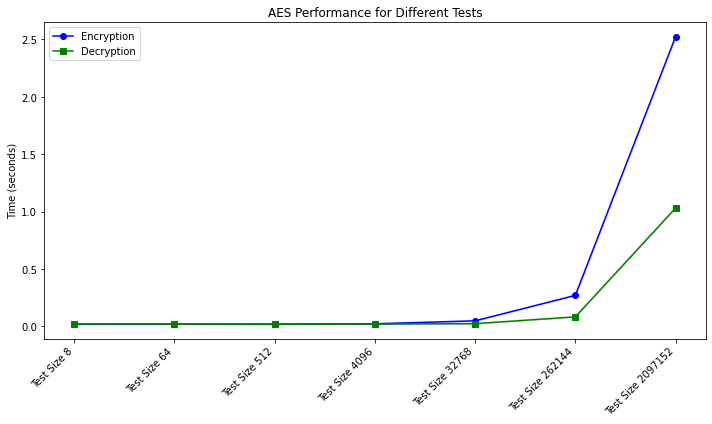

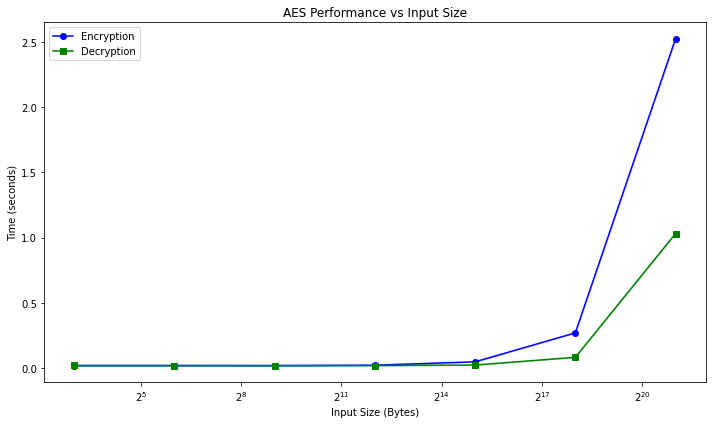

In [38]:
results = []
print("\nSame File for Different Sizes")
for i in range(len(sizes)):
    result = test_aes([files[i][0]], 1000, 25)
    results.append(result)
    # print_results(sizes[i], result)
plot_all_results([f"Test Size {size}" for size in sizes], sizes, results)


Random Files for Different Sizes


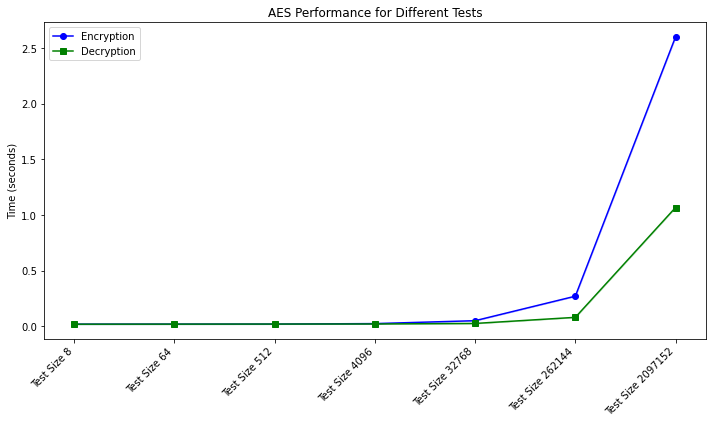

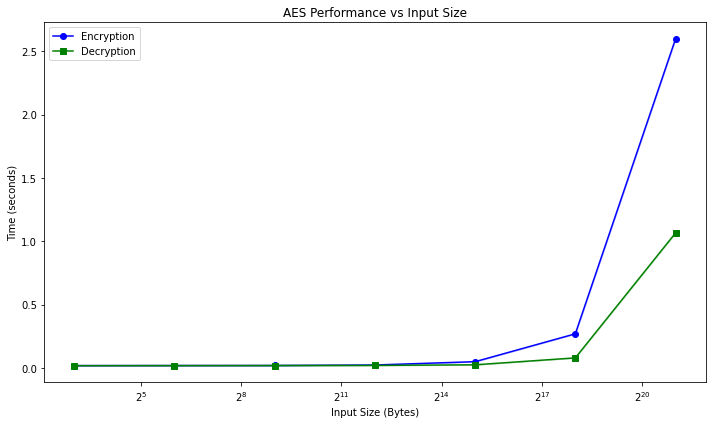

In [39]:
results = []
print("\nRandom Files for Different Sizes")
for i in range(len(sizes)):
    result = test_aes([files[i][0]], 1000, 25)
    results.append(result)
    # print_results(sizes[i], result)
plot_all_results([f"Test Size {size}" for size in sizes],sizes, results)

for i in range(len(sizes)):
    for file in files[i]:
        if os.path.isfile(file):
            os.remove(file)

In [40]:
print_all_confidence_intervals(results)

Encryption Test 1 99% Confidence Interval: (19086.902, 19088.392) µs
Decryption Test 1 99% Confidence Interval: (18719.693, 18719.698) µs
Encryption Test 2 99% Confidence Interval: (19605.717, 19607.517) µs
Decryption Test 2 99% Confidence Interval: (19271.948, 19272.022) µs
Encryption Test 3 99% Confidence Interval: (19969.530, 19969.558) µs
Decryption Test 3 99% Confidence Interval: (19886.858, 19887.479) µs
Encryption Test 4 99% Confidence Interval: (23975.782, 23978.315) µs
Decryption Test 4 99% Confidence Interval: (20559.626, 20559.672) µs
Encryption Test 5 99% Confidence Interval: (50189.871, 50191.570) µs
Decryption Test 5 99% Confidence Interval: (25493.499, 25494.088) µs
Encryption Test 6 99% Confidence Interval: (270105.557, 270263.579) µs
Decryption Test 6 99% Confidence Interval: (80214.886, 80216.177) µs
Encryption Test 7 99% Confidence Interval: (2594974.305, 2601159.557) µs
Decryption Test 7 99% Confidence Interval: (1066220.472, 1066359.455) µs
